# Library Imports and Setup

In [10]:
# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet

# Core Libraries
import numpy as np

# Monkey patch NumPy deprecated aliases (for compatibility with older libraries like MXNet)
deprecated_aliases = {
    'bool': bool,
    'int': int,
    'float': float,
    'object': object,
    'long': int,
}
for alias, actual in deprecated_aliases.items():
    if not hasattr(np, alias):
        setattr(np, alias, actual)

# Other Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import tarfile
import datetime
import json
import time
import io
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# MXNet
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.numpy as mx_np  # Don't call set_np()

# AWS SageMaker and Boto3
import boto3
from botocore.exceptions import ClientError
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sagemaker.inputs import TrainingInput


# Setup and configuration for AWS SageMaker

In [2]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/mall/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/30/25 23:28:48] INFO     Found credentials from IAM Role:                                   ]8;id=801575;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=775776;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=760189;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=939679;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=296834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=901898;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/30/25 23:28:49] INFO     Same images used for training and inference. Defaulting to image     ]8;id=417143;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=326576;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=232641;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=55723;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::662777067338:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

Relevant features include:
- Credit Utilization Ratio
- Outstanding Debt
- Monthly Balance
- Number of Delayed Payments

These columns are cleaned so that any invalid data is set to the median of the column.
The data is already split into a training and test set.

In [3]:
# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Step 2: Select Relevant Features
# Focus on the features 'Credit_Utilization_Ratio', 'Outstanding_Debt', 'Monthly_Balance', 'Num_of_Delayed_Payment', and 'Payment_Behaviour' for analysis.
df_train = df_train[['Credit_Utilization_Ratio', 'Outstanding_Debt', 'Monthly_Balance', 'Num_of_Delayed_Payment']]
df_test = df_test[['Credit_Utilization_Ratio', 'Outstanding_Debt', 'Monthly_Balance', 'Num_of_Delayed_Payment']]

# Ensure numerical data is numerical - Force errors to NaN - Replace NaN with median
cols_to_clean = ['Credit_Utilization_Ratio', 'Outstanding_Debt', 'Monthly_Balance', 'Num_of_Delayed_Payment']
df_train[cols_to_clean] = df_train[cols_to_clean].apply(pd.to_numeric, errors='coerce')
df_test[cols_to_clean] = df_test[cols_to_clean].apply(pd.to_numeric, errors='coerce')
for col in cols_to_clean:
    df_train[col].fillna(df_train[col].median(), inplace=True)
    df_test[col].fillna(df_test[col].median(), inplace=True)


# Step 3: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
train_np = df_train.values.astype('float32')
test_np = df_test.values.astype('float32')

# Step 4: Save Preprocessed Data
# Save the preprocessed dataset to a CSV file, without the index.
df_train.to_csv('train_data_processed.csv', index=False)
df_test.to_csv('test_data_processed.csv', index=False)

# Confirming the data has been preprocessed and saved.
print("Preprocessed dataset saved as 'train_data_processed.csv' and 'test_data_processed.csv'.")

# Display the first few rows of the processed dataset to verify the preprocessing steps.
print(df_train.head())
print(df_test.head())

/tmp/ipykernel_7332/2718107838.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('data/train.csv')


Preprocessed dataset saved as 'train_data_processed.csv' and 'test_data_processed.csv'.
   Credit_Utilization_Ratio  Outstanding_Debt  Monthly_Balance  \
0                 26.822620            809.98       312.494089   
1                 31.944960            809.98       284.629162   
2                 28.609352            809.98       331.209863   
3                 31.377862            809.98       223.451310   
4                 24.797347            809.98       341.489231   

   Num_of_Delayed_Payment  
0                     7.0  
1                    14.0  
2                     7.0  
3                     4.0  
4                    14.0  
   Credit_Utilization_Ratio  Outstanding_Debt  Monthly_Balance  \
0                 35.030402            809.98       186.266702   
1                 33.053114            809.98       361.444004   
2                 33.811894            809.98       264.675446   
3                 32.430559            809.98       343.826873   
4                

# Plot the Preprocessed Data

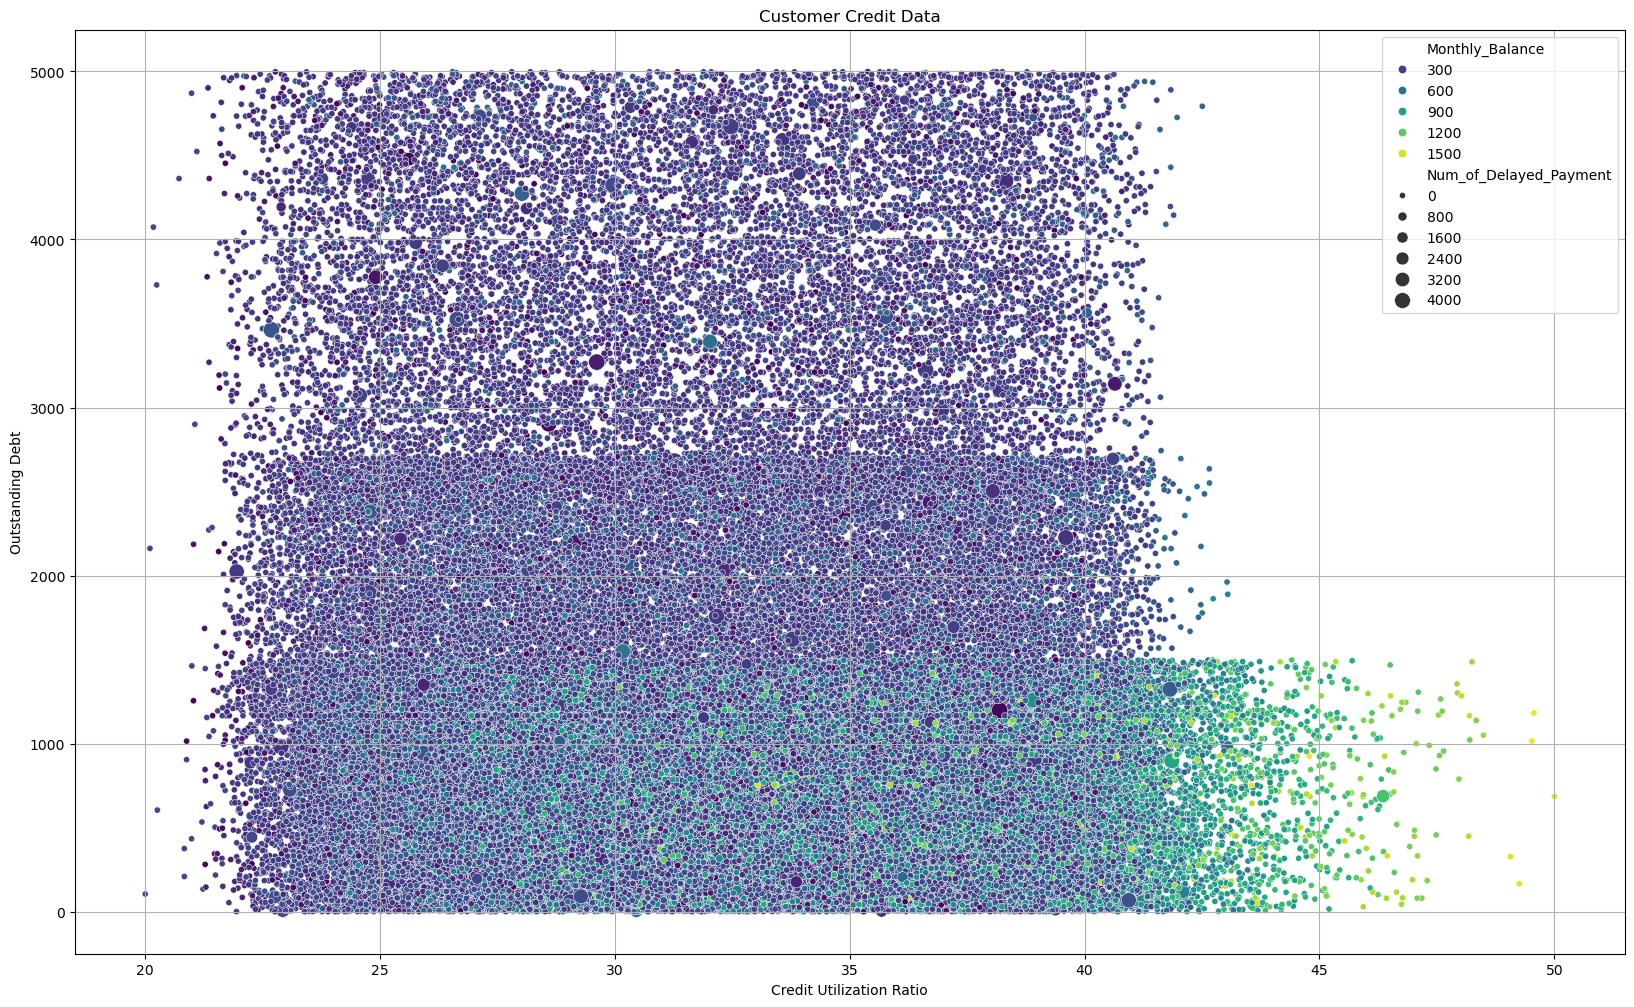

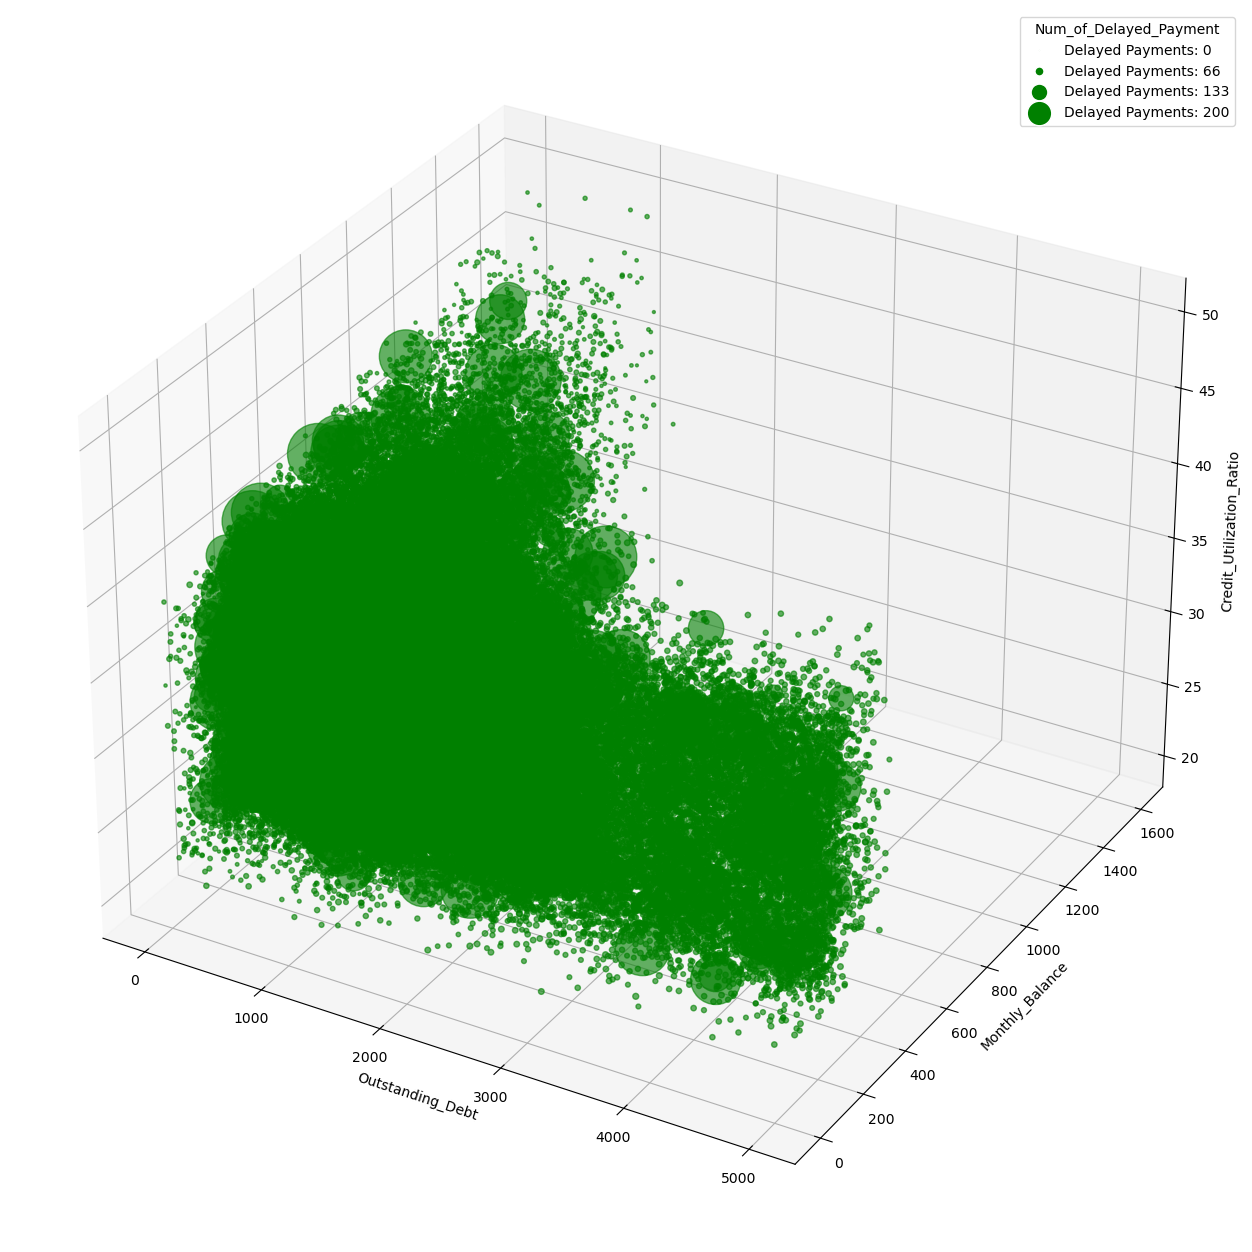

In [17]:
"""2D scatter plot"""
# Set the size of the plot
plt.figure(figsize=(20, 12))

# Create scatter plot using Seaborn
sns.scatterplot(
    x='Credit_Utilization_Ratio', 
    y='Outstanding_Debt', 
    data=df_train, 
    hue='Monthly_Balance',        # Third dimension: Color
    size='Num_of_Delayed_Payment', # Fourth dimension: Marker size
    # style='Gender',             # Fifth dimension: Marker style
    palette='viridis',          # Custom color palette
    sizes=(20, 140)             # Marker size range
)

# Setting the title and labels of the plot
plt.title('Customer Credit Data')
plt.xlabel('Credit Utilization Ratio')
plt.ylabel('Outstanding Debt')

# Enabling grid for better readability
plt.grid(True)

# Display the plot
plt.show()

"""3D scatter plot"""
# Step 1: Create a 3D scatter plot
# Initialize a figure with a specific size for the 3D scatter plot.
fig = plt.figure(figsize=(25, 16))

# Add a 3D subplot to the figure
# '111' indicates 1x1 grid, first subplot. 'projection='3d'' is used to create a 3D projection.
ax = fig.add_subplot(111, projection='3d')

# Step 2: Plot data points, showing Num_of_Delayed_Payment by point size
# Normalize the 4th (continuous) variable for point size scaling
min_size, max_size = 5, 100  # Define a range for point sizes
min_delayed_pmts = 0
max_delayed_pmts = 200
point_sizes = min_size + (df_train['Num_of_Delayed_Payment'] - min_delayed_pmts) \
                        / (max_delayed_pmts - min_delayed_pmts) * (max_size - min_size)

# Plot data points with size representing the 4th variable
scatter = ax.scatter(df_train['Outstanding_Debt'],
                     df_train['Monthly_Balance'],
                     df_train['Credit_Utilization_Ratio'],
                     s=point_sizes,
                     c='green',  # Single color for all points
                     alpha=0.6)

# Step 3: Set labels, legend, axes
# Adding axis labels and a legend to make the plot more informative.
ax.set_xlabel('Outstanding_Debt')
ax.set_ylabel('Monthly_Balance')
ax.set_zlabel('Credit_Utilization_Ratio')

# Manually create legend handles for point sizes
size_legend = [min_delayed_pmts, (min_delayed_pmts + max_delayed_pmts)//3, 2*(min_delayed_pmts + max_delayed_pmts)//3, max_delayed_pmts]
legend_handles = [mlines.Line2D([], [], color='w', marker='o', markersize=size/12 + 1, 
                                markerfacecolor='green', label=f'Delayed Payments: {size}')
                  for size in size_legend]
ax.legend(handles=legend_handles, title="Num_of_Delayed_Payment")

# Set axis limits
# ax.set_xlim(18, 70)  # Age range from 18 to 70
# ax.set_ylim(15, 150)  # Annual income range from 15k to 150k
# ax.set_zlim(0, 100)   # Spending score from 0 to 100

# Enabling grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# KMeans Model Training

In [5]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/credit/kmeans/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-credit-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=4  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(train_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

[03/30/25 17:06:55] INFO     Same images used for training and inference. Defaulting to image     ]8;id=570534;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=57877;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=218890;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=959795;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=238212;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=400491;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=262956;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=363742;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-17-06-55-711        ]8;id=24939;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=541699;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 17:06:56] INFO     Same images used for training and inference. Defaulting to image     ]8;id=603406;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=64070;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=318381;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=588004;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=343904;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=285549;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=434605;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=163551;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-17-06-56-971        ]8;id=442924;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=370372;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 17:06:58] INFO     Same images used for training and inference. Defaulting to image     ]8;id=380227;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=307853;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=3872;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=375807;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=675047;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=906671;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=559547;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=263222;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-17-06-58-225        ]8;id=155820;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=106459;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 17:06:59] INFO     Same images used for training and inference. Defaulting to image     ]8;id=192821;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=29526;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=489746;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=646854;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=786972;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=536057;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=695242;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=314931;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-17-06-59-886        ]8;id=590742;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=915386;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 17:07:01] INFO     Same images used for training and inference. Defaulting to image     ]8;id=843372;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=925862;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=997327;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=152857;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=340829;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=152485;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=781357;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=45966;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-17-07-01-128        ]8;id=637525;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=398692;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 17:07:02] INFO     Same images used for training and inference. Defaulting to image     ]8;id=944769;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=767173;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=738043;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=949639;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=712727;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=528317;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=263422;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=485695;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-17-07-02-625        ]8;id=864993;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=529672;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

  k Value  S3 Model Artifact Path
---------  -----------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-662777067338/sagemaker/credit/kmeans/output/kmeans-2025-03-30-17-06-55-711/output/model.tar.gz
        3  s3://sagemaker-us-east-1-662777067338/sagemaker/credit/kmeans/output/kmeans-2025-03-30-17-06-56-971/output/model.tar.gz
        4  s3://sagemaker-us-east-1-662777067338/sagemaker/credit/kmeans/output/kmeans-2025-03-30-17-06-58-225/output/model.tar.gz
        5  s3://sagemaker-us-east-1-662777067338/sagemaker/credit/kmeans/output/kmeans-2025-03-30-17-06-59-886/output/model.tar.gz
        6  s3://sagemaker-us-east-1-662777067338/sagemaker/credit/kmeans/output/kmeans-2025-03-30-17-07-01-128/output/model.tar.gz
        7  s3://sagemaker-us-east-1-662777067338/sagemaker/credit/kmeans/output/kmeans-2025-03-30-17-07-02-625/output/model.tar.gz


# Determine K through Elbow Plot

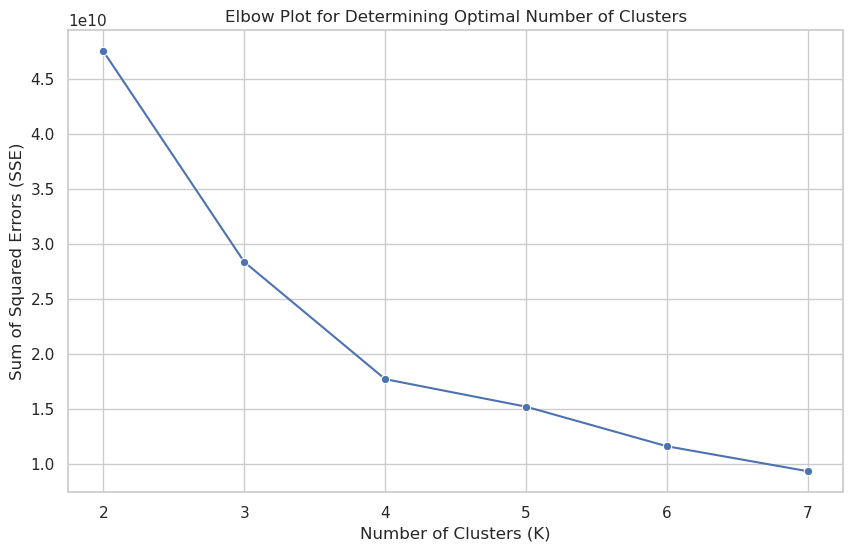

In [6]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((train_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate SSE for this value of K
        sse = np.sum((train_np - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.show()

# Determine K through using Silhouette Method

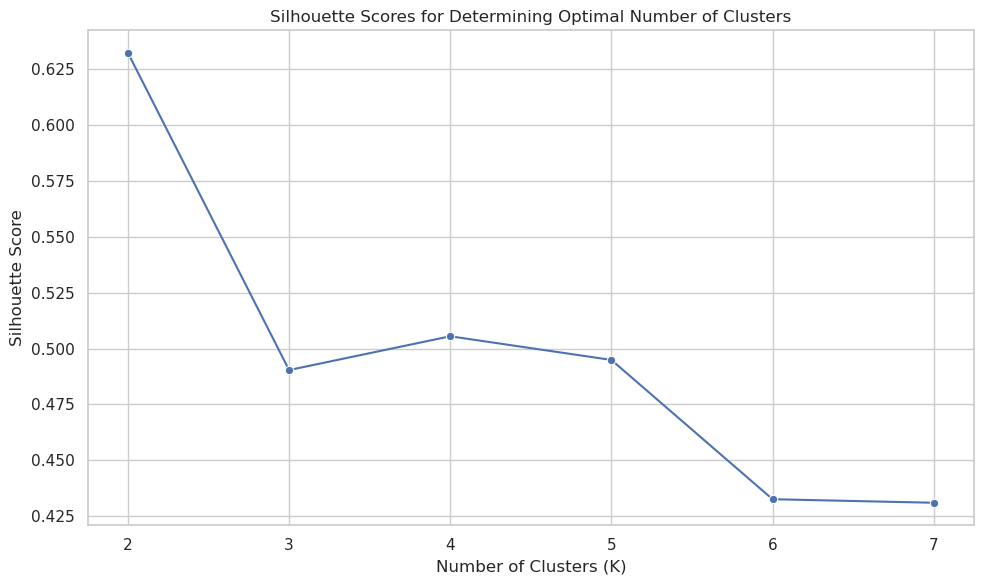

In [7]:
# List to store the silhouette scores for each value of K
silhouette_scores = []

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((train_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(train_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")

# KMeans Hyperparameter Tuning (HPT)

[03/30/25 17:27:10] WARNING  No finished training job found associated with this estimator.       ]8;id=485102;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=561895;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=487882;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=90055;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name: kmeans-250330-1727       ]8;id=860032;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=616945;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\

..............................................................................................!
!

2025-03-30 17:31:48 Starting - Found matching resource for reuse
2025-03-30 17:31:48 Downloading - Downloading the training image
2025-03-30 17:31:48 Training - Training image download completed. Training in progress.
2025-03-30 17:31:48 Uploading - Uploading generated training model
2025-03-30 17:31:48 Completed - Resource reused by training job: kmeans-250330-1727-005-1750fc47
Best hyperparameters:
_tuning_objective_metric: test:msd
epochs: 8
extra_center_factor: 9
feature_dim: 4
init_method: random
k: 4
mini_batch_size: 4870
Model Metrics for Best Model:
SSE: 17586759680.0


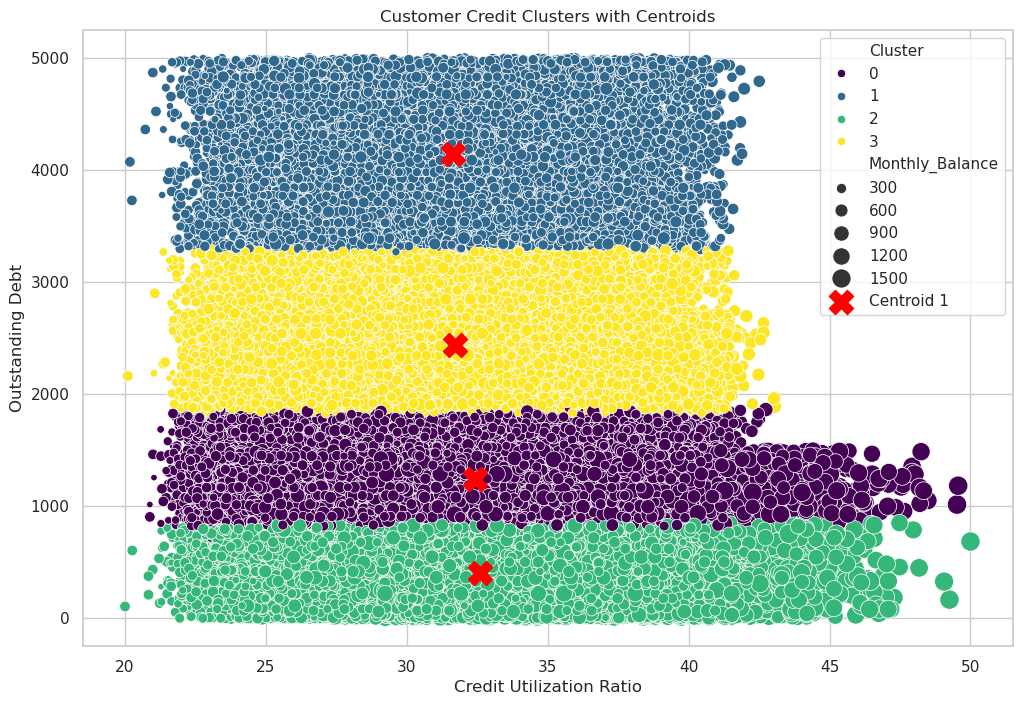

In [8]:
# KMeans Hyperparameter Tuning (HPT) for Credit Data
# Specify the best K value based on the elbow plot
best_k = 4  # Update this based on your elbow plot analysis

# Initialize KMeans estimator with specified configuration and hyperparameters
kmeans = sagemaker.estimator.Estimator(
    image_uri=image_uri,  # Get the correct KMeans image URI
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{sagemaker_session.default_bucket()}/sagemaker/credit/kmeans/output',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'k': best_k,
        'feature_dim': 4  # Number of features: Credit_Utilization_Ratio, Outstanding_Debt, Monthly_Balance, Num_of_Delayed_Payment
    }
)

# Define hyperparameter ranges for tuning
hyperparameter_ranges = {
    'extra_center_factor': IntegerParameter(4, 10),
    'init_method': CategoricalParameter(['random', 'kmeans++']),
    'epochs': IntegerParameter(1, 10),
    'mini_batch_size': IntegerParameter(1000, 5000)  # Adjusted for potentially smaller credit dataset
}

# Metric to optimize during hyperparameter tuning
objective_metric_name = 'test:msd'  # Mean squared distance

# Split data into training and testing sets
train_data, test_data = train_np, test_np

# Convert and upload training data to S3 in recordIO-wrapped protobuf format
def upload_to_s3(data, prefix):
    buf = io.BytesIO()
    write_numpy_to_dense_tensor(buf, data, labels=None)
    buf.seek(0)
    key = f'sagemaker/credit/kmeans/{prefix}/data.pbr'
    s3_client.upload_fileobj(buf, sagemaker_session.default_bucket(), key)
    return f's3://{sagemaker_session.default_bucket()}/{key}'

s3_train_data = upload_to_s3(train_data, 'train')
s3_test_data = upload_to_s3(test_data, 'test')

# Define training and testing inputs for SageMaker
train_input = TrainingInput(s3_data=s3_train_data, content_type='application/x-recordio-protobuf')
test_input = TrainingInput(s3_data=s3_test_data, content_type='application/x-recordio-protobuf')

# Configure and initialize hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=kmeans,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type='Minimize',
    max_jobs=10,
    max_parallel_jobs=2
)

# Start hyperparameter tuning job
tuner.fit({'train': train_input, 'test': test_input})
tuner.wait()  # Block until tuning job completes

# Fetch the best model and its hyperparameters
best_estimator = tuner.best_estimator()
print("Best hyperparameters:")
for key, value in best_estimator.hyperparameters().items():
    print(f"{key}: {value}")

# Download the best model artifacts from S3
best_model_s3_uri = best_estimator.model_data
local_path = '/tmp/best_model_credit.tar.gz'
s3_client.download_file(
    Bucket=sagemaker_session.default_bucket(),
    Key=best_model_s3_uri.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
    Filename=local_path
)

# Extract model parameters
with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model_credit')

# Load the KMeans model parameters and compute cluster assignments
kmeans_best_params = mx.ndarray.load('/tmp/best_model_credit/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()
distances_best = np.sqrt(((train_np - centroids_best[:, np.newaxis])**2).sum(axis=2))
cluster_labels = np.argmin(distances_best, axis=0)

# Add cluster labels to the original DataFrame
df_train['Cluster'] = cluster_labels

# Compute model metrics
sse_best = np.sum((train_np - centroids_best[cluster_labels])**2)
print(f"Model Metrics for Best Model:\nSSE: {sse_best}")

# Visualize the clustering results (using the first two features for visualization)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_train, 
    x='Credit_Utilization_Ratio', 
    y='Outstanding_Debt', 
    hue='Cluster', 
    palette='viridis',
    size='Monthly_Balance',
    sizes=(20, 200)
)
# Plot centroids
for i, centroid in enumerate(centroids_best):
    plt.scatter(centroid[0], centroid[1], s=300, c='red', marker='X', label=f'Centroid {i+1}' if i == 0 else None)

plt.title('Customer Credit Clusters with Centroids')
plt.xlabel('Credit Utilization Ratio')
plt.ylabel('Outstanding Debt')
plt.legend()
plt.grid(True)
plt.show()

# Model Deployment to SageMaker Endpoint

In [9]:
# Specify the endpoint name
endpoint_name = 'mall-kmeans-one-a-HPT'

# Specify the endpoint configuration name
endpoint_config_name = 'mall-kmeans-one-a-HPT'

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')
# Check if the endpoint configuration already exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

    # Wait for the endpoint configuration to be deleted
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print("Waiting for endpoint configuration to be deleted...")
            time.sleep(5)  # Wait for 5 seconds before checking again
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break  # Exit the loop if the endpoint configuration is deleted
            else:
                raise

except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
    else:
        raise

# Check if the endpoint already exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

    # Wait for the endpoint to be deleted
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print("Waiting for endpoint to be deleted...")
            time.sleep(5)  # Wait for 5 seconds before checking again
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break  # Exit the loop if the endpoint is deleted
            else:
                raise

except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')
    else:
        raise

# Find the S3 URI for the best model
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model artifacts
best_model = Model(model_data=best_model_s3_uri,
                   image_uri=image_uri,
                   role=role,
                   sagemaker_session=sagemaker_session)

# Deploy the model as an endpoint
best_model.deploy(initial_instance_count=1, instance_type='ml.m5.large', endpoint_name=endpoint_name)


Endpoint configuration "mall-kmeans-one-a-HPT" does not exist.
Endpoint "mall-kmeans-one-a-HPT" does not exist.


[03/30/25 17:35:33] INFO     Creating model with name: kmeans-2025-03-30-17-35-33-556               ]8;id=55934;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=949520;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/30/25 17:35:34] INFO     Creating endpoint-config with name mall-kmeans-one-a-HPT               ]8;id=124745;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=381864;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name mall-kmeans-one-a-HPT                      ]8;id=543068;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=505206;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-------!

# Cluster Associations and Centroids

In [22]:
# Create a Predictor object for the deployed endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

while True:
    # Prompt for Annual Income and Spending Score
    credit_util = input("Enter Credit Utilization Ratio (float) or type 'quit' to exit: ")
    if credit_util.lower() == 'quit':
        break
    debt = input("Enter Outstanding Debt (k$) or type 'quit' to exit: ")
    if debt.lower() == 'quit':
        break
    balance = input("Enter Monthly Balance (k$) or type 'quit' to exit: ")
    if balance.lower() == 'quit':
        break
    delayed_pmts = input("Enter Number of Delayed Payments (integer) or type 'quit' to exit: ")
    if delayed_pmts.lower() == 'quit':
        break

    # Prepare the data for prediction
    data = f'{credit_util},{debt},{balance},{delayed_pmts}\n'
    # data = json.dumps({"instances": [[float(annual_income), float(spending_score)]]})

    # Make prediction
    response = predictor.predict(data, initial_args={"ContentType": "text/csv"})

    # Parse the prediction response
    response_json = json.loads(response)
    cluster = response_json['predictions'][0]['closest_cluster']
    distance = response_json['predictions'][0]['distance_to_cluster']

    # Print the cluster assignment
    print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")

print("Program exited.")


Enter Credit Utilization Ratio (float) or type 'quit' to exit:  21.5
Enter Outstanding Debt (k$) or type 'quit' to exit:  2000
Enter Monthly Balance (k$) or type 'quit' to exit:  200
Enter Number of Delayed Payments (integer) or type 'quit' to exit:  0


The data point belongs to Cluster 3 with a distance of 526.02 to the cluster center.


Enter Credit Utilization Ratio (float) or type 'quit' to exit:  50.1
Enter Outstanding Debt (k$) or type 'quit' to exit:  1000
Enter Monthly Balance (k$) or type 'quit' to exit:  300
Enter Number of Delayed Payments (integer) or type 'quit' to exit:  1


The data point belongs to Cluster 0 with a distance of 296.28 to the cluster center.


Enter Credit Utilization Ratio (float) or type 'quit' to exit:  quit


Program exited.


# Delete the Endpoint and Endpoint Config

In [ ]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Create a SageMaker client
    sagemaker_client = boto3.client('sagemaker')

    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")
